In [ ]:
#Import block
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import math
from PIL import Image
import glob
import librosa
from random import sample
import librosa.display
import sklearn.metrics

In [ ]:
# arr1 = np.array([10, -2, -3])
arr1 = np.array([3.2, 5.1, -1.7])
arr2 = np.array([10, 9, 9])
arr3 = np.array([10, -100, -100])

In [ ]:
softmax_arr1 = np.exp(arr1) / np.sum(np.exp(arr1))
softmax_arr2 = np.exp(arr2) / np.sum(np.exp(arr2))
softmax_arr3 = np.exp(arr3) / np.sum(np.exp(arr3))

In [ ]:
#Hinge loss for above arrays
hingeLoss_arr1 = np.sum(np.maximum(0, arr1 - (arr1[0] + 1) * np.ones(len(arr1))))
# hingeLoss_arr2 = np.sum(np.maximum(0, arr2 - (arr2[0] + 1) * np.ones(len(arr2))))
# hingeLoss_arr3 = np.sum(np.maximum(0, arr3 - (arr3[0] + 1) * np.ones(len(arr3))))

In [ ]:
hingeLoss_arr1

0.8999999999999995

# Question 5

## Pre-Training

In [ ]:
#Import the images as Trainging and Test Data
X_test_path = '/content/drive/MyDrive/MLSP/Assignment_1/emotion_classification/test/*.gif'
X_train_path = '/content/drive/MyDrive/MLSP/Assignment_1/emotion_classification/train/*.gif'

In [ ]:
# plt.imshow(X_train[0])
X_train = np.zeros((20, 101, 101))
label_train = np.zeros((20, 1))
X_test = np.zeros((10, 101, 101))
label_test = np.zeros((10, 1))
count = 0
for filename in glob.glob(X_train_path): #assuming gif
    im=Image.open(filename)
    im = np.array(im)
    X_train[count] = im/255
    if 'happy' in filename:
      label_train[count] = 1
    else:
      label_train[count] = 0
    count += 1

count = 0
for filename in glob.glob(X_test_path): #assuming gif
    im=Image.open(filename)
    im = np.array(im)
    X_test[count] = im/255
    if 'happy' in filename:
      label_test[count] = 1
    else:
      label_test[count] = 0
    count += 1

###PCA

###### Data Preparation

In [ ]:
X_train = X_train.reshape(20, -1).T

###### PCA Implementation

In [ ]:
def constructDesignMatrix(X_train):
  X_train_mean = np.expand_dims(X_train.mean(axis=1), axis=1)
  designMatrix = (X_train - X_train_mean).T
  return designMatrix

def PCA(X_train, principalComponents = 10):
  #Data Processing
  X_train_mean = np.expand_dims(X_train.mean(axis=1), axis=1)
  designMatrix = (X_train - X_train_mean).T
  X_train_cov =  np.cov(designMatrix)

  # Find the Eigen Values from Eigen Decomposition
  eigenvalues, eigenvectors = np.linalg.eigh(X_train_cov)
  eigenvalues = eigenvalues[::-1]
  eigenvectors = eigenvectors[:, ::-1]
  transformationEV = eigenvalues[:principalComponents]
  transformationMatrix = eigenvectors[:, :principalComponents]

  # Find the actual Eigen Vectors
  originalTransformationMatrix = np.zeros((len(X_train),principalComponents))

  for i in range(principalComponents):
    originalTransformationMatrix[:,i] = (designMatrix.T @ transformationMatrix[:,i])/math.sqrt((len(eigenvalues) * eigenvalues[i]))

  # Project Data to Principal Components
  X_train_pca = originalTransformationMatrix.T @ designMatrix.T

  #Reconstruc the Image from projected Data
  X_train_reconstructed = originalTransformationMatrix @ X_train_pca + X_train_mean

  return X_train_reconstructed, X_train_pca, originalTransformationMatrix, X_train_mean

In [ ]:
X_train_reconstructed, X_train_pca, originalTransformationMatrix, X_train_mean = PCA(X_train, 18)

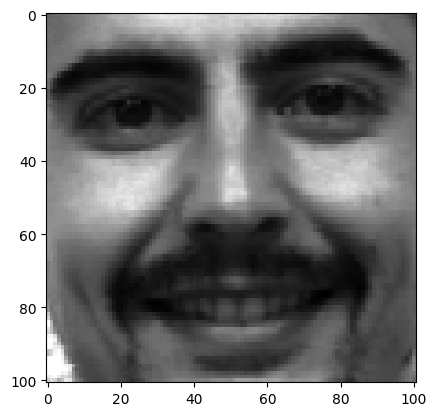

In [ ]:
plt.imshow(X_train.T[2].reshape(101, 101), cmap='gray')

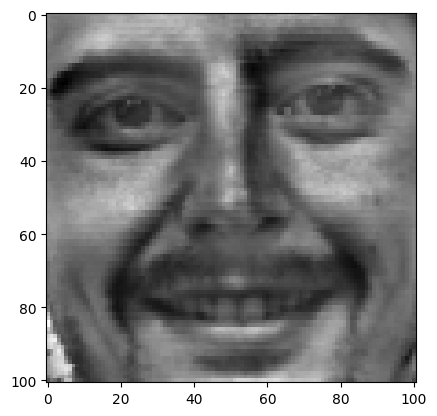

In [ ]:
plt.imshow(X_train_reconstructed.T[2].reshape(101, 101), cmap='gray')


### LDA

##### Calculate the Between class covariance matrix and within class covariance matrix

In [ ]:
#Segregate the data based on the labels
def segregateData(X_train_pca, label_train):
  X_trainHappy = np.zeros((len(X_train_pca),1))
  X_trainSad = np.zeros((len(X_train_pca),1))
  countHappy = 0
  countSad = 0
  for i in range(len(X_train_pca[0])):
    if label_train[i] == 1:
      X_trainHappy = np.append(X_trainHappy, np.expand_dims(X_train_pca[:,i], axis = 1), axis = 1)
      countHappy += 1
    else:
      X_trainSad =np.append(X_trainSad, np.expand_dims(X_train_pca[:,i], axis = 1), axis = 1)
      countSad += 1

  X_trainHappy = X_trainHappy[:,1:]
  X_trainSad = X_trainSad[:,1:]
  return X_trainHappy, X_trainSad, countHappy, countSad

#Generate the within-Class Covariance Matrix
def generateWithinClassCV(X_trainHappy, X_trainSad, countHappy, countSad, X_trainHappyMean, X_trainSadMean):
  dimentions = len(X_trainHappy)
  X_trainHappySum = np.zeros((dimentions, dimentions))
  X_trainSadSum = np.zeros((dimentions, dimentions))

  for i in range(countHappy):
    diff = np.expand_dims(X_trainHappy[:,i], axis = 1) - X_trainHappyMean
    X_trainHappySum += np.outer(diff, diff)

  for i in range(countSad):
    diff = np.expand_dims(X_trainSad[:,i], axis = 1) - X_trainSadMean
    X_trainSadSum += np.outer(diff, diff)

  withinClassCV = (X_trainHappySum / (countHappy - 1) + X_trainSadSum / (countSad - 1))
  return withinClassCV

#Between Class Variance
def generateBetweenClassCV(diff):
  return np.outer(diff, diff)

#Generate the class mean difference
def generateClassMeanDiff(X_trainHappy, X_trainSad):
  X_trainHappyMean = X_trainHappy.mean(axis = 1, keepdims=True)
  X_trainSadMean = X_trainSad.mean(axis = 1, keepdims=True)
  diff = X_trainHappyMean - X_trainSadMean
  return X_trainHappyMean, X_trainSadMean, diff

#### Finding the LDA Direction.
The LDA direction is the eigen vector of highest eigen value of the matrix $S_w^{-1}S_b$

In [ ]:
# Constructing the LDA Direction
def constructLDA(withinClassCV, diff):
  withinClassInv = np.linalg.inv(withinClassCV)
  ldaDirection = withinClassInv @ diff
  ldaDirectionNormalised = ldaDirection / np.linalg.norm(ldaDirection)
  return ldaDirectionNormalised

#Project the class data to LDA direction

def projectToLDA(ldaDirectionNormalised, X_trainHappy, X_trainSad):
  happy_lda_values = ldaDirectionNormalised.T @ X_trainHappy
  sad_lda_values = ldaDirectionNormalised.T @ X_trainSad
  return happy_lda_values, sad_lda_values

#Plot the LDA Labels
def plotLDA(happy_lda_values, sad_lda_values):
  plt.figure(figsize=(10, 6))
  plt.scatter(happy_lda_values, [0] * len(happy_lda_values[0]), color='blue', label='Happy')
  plt.scatter(sad_lda_values, [0] * len(sad_lda_values[0]), color='red', label='Sad')
  plt.xlabel("1D LDA Feature")
  plt.yticks([])  # Remove Y-axis ticks since it's 1D
  plt.axvline(x=0, color='gray', linestyle='--', alpha=0.9)
  plt.legend()
  plt.title("LDA Projection of Images to 1D Space")
  plt.show()

In [ ]:
def LDA(X_train_pca, label_train):
  X_trainHappy, X_trainSad, countHappy, countSad = segregateData(X_train_pca, label_train)
  X_trainHappyMean, X_trainSadMean, diff = generateClassMeanDiff(X_trainHappy, X_trainSad)
  withinClassCV = generateWithinClassCV(X_trainHappy, X_trainSad, countHappy, countSad, X_trainHappyMean, X_trainSadMean)
  betweenClassVariance = generateBetweenClassCV(diff)
  ldaDirectionNormalised = constructLDA(withinClassCV, diff)
  fisher_criterion = (ldaDirectionNormalised.T @ betweenClassVariance @ ldaDirectionNormalised)/(ldaDirectionNormalised.T @ withinClassCV @ ldaDirectionNormalised)

  happy_lda_values, sad_lda_values = projectToLDA(ldaDirectionNormalised, X_trainHappy, X_trainSad)

  plotLDA(happy_lda_values, sad_lda_values)
  return ldaDirectionNormalised, happy_lda_values, sad_lda_values, fisher_criterion

## Training

In [ ]:
def PCA_LDA(X_train, label_train, principalComponents = 10):
  X_train_reconstructed, X_train_pca, originalTransformationMatrix, X_train_mean = PCA(X_train, principalComponents)
  ldaDirectionNormalised, happy_lda_values, sad_lda_values, fisher_criterion= LDA(X_train_pca, label_train)
  return originalTransformationMatrix, ldaDirectionNormalised, happy_lda_values, sad_lda_values, fisher_criterion

#### We get the maximum separation in the case of taking 18 principal components. The choosen threshold is taken as 0 as the data is already normalised.

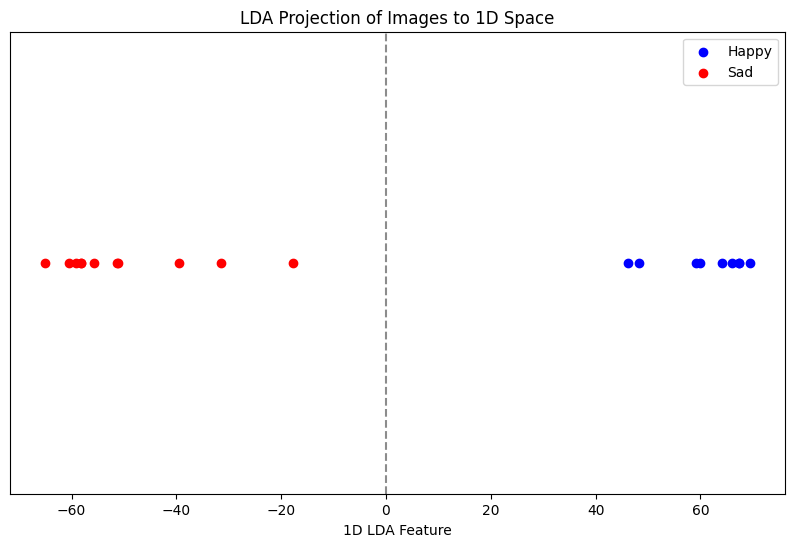

In [ ]:
originalTransformationMatrix, ldaDirectionNormalised, happy_lda_values, sad_lda_values,fisher_criterion = PCA_LDA(X_train, label_train, 18)

In [ ]:
list_FC=[]
for i in range(1, 19):
  originalTransformationMatrix, ldaDirectionNormalised, happy_lda_values, sad_lda_values,fisher_criterion = PCA_LDA(X_train, label_train, i)
  list_FC.append(fisher_criterion.squeeze())

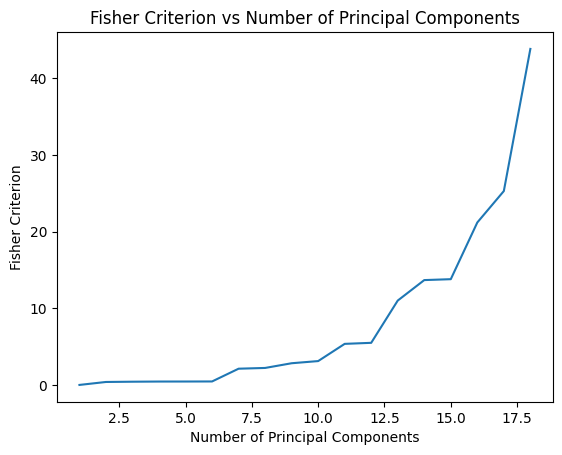

In [ ]:
plt.plot(range(1, 19) ,list_FC)
plt.xlabel('Number of Principal Components')
plt.ylabel('Fisher Criterion')
plt.title('Fisher Criterion vs Number of Principal Components')
plt.show()

## Testing

In [ ]:
def predict(test_lda_values):
  prediction = []
  for i in range(len(test_lda_values[0])):
    if test_lda_values[0][i] > 0:
      prediction.append(1)
    else:
      prediction.append(0)

  return prediction

def findAccuracy(prediction, trueLabel):
  correct = 0
  for i in range(len(prediction)):
    if prediction[i] == trueLabel[i]:
      correct += 1
  return correct/len(prediction)

def testData(X_test, label_test, originalTransformationMatrix, ldaDirectionNormalised):
  designMatrixTest = constructDesignMatrix(X_test.reshape(10, -1).T)
  X_test_pca = originalTransformationMatrix.T @ designMatrixTest.T
  test_lda_values = ldaDirectionNormalised.T @ X_test_pca
  prediction = predict(test_lda_values)
  trueLabel = label_test[:,0].tolist()
  accuracy = findAccuracy(prediction, trueLabel)
  return prediction,accuracy, test_lda_values


In [ ]:
prediction, accuracy, test_lda_values = testData(X_test, label_test, originalTransformationMatrix, ldaDirectionNormalised)

In [ ]:
print(f"The accurancy of the PCA + LDA is {accuracy * 100}")

The accurancy of the PCA + LDA is 90.0


In [ ]:
X_test_happy = []
X_test_sad = []

for i in range(len(label_test)):
  if label_test[i] == 1:
    X_test_happy.append(test_lda_values[0][i])
  else:
    X_test_sad.append(test_lda_values[0][i])

In [ ]:
# Convert lists to numpy arrays for easier handling
X_test_happy = np.expand_dims(np.array(X_test_happy), axis=1)
X_test_sad = np.expand_dims(np.array(X_test_sad), axis=1)

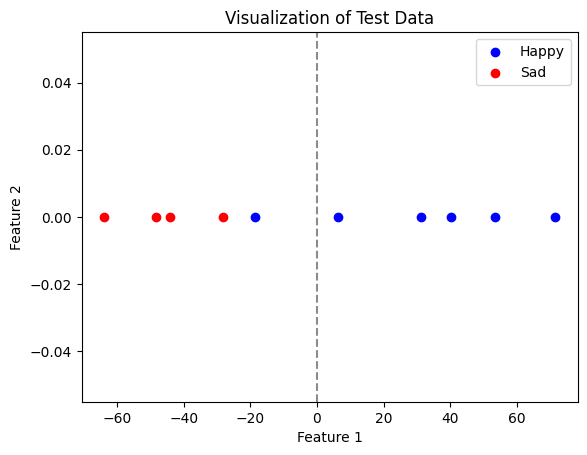

In [ ]:
# Check if arrays are not empty before plotting
if X_test_happy.size > 0:
    plt.scatter(X_test_happy[:, 0], [0] * X_test_happy[:, 0], color='blue', label='Happy')
if X_test_sad.size > 0:
    plt.scatter(X_test_sad[:, 0], [0] * X_test_sad[:, 0], color='red', label='Sad')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of Test Data')
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.9)
plt.legend()
plt.show()

# Question 6

In [ ]:
def compute_mel_spectrogram(audio_path, sampleRate=16000, n_mels=128, windowLength=320, hopLength=160):
    # Load the audio file
    y, _ = librosa.load(audio_path, sr=sampleRate)

    # Compute mel spectrogram
    melSpectrogram = librosa.feature.melspectrogram(y=y, sr=sampleRate, n_mels=n_mels,
                                                     win_length=windowLength, hop_length=hopLength)

    # Compute T (duration in ms / 10)
    T = melSpectrogram.shape[1]

    return melSpectrogram, T

# Example usage
clean_audio = "/content/drive/MyDrive/MLSP/Assignment_1/speechFiles/clean.wav"
noisy_audio = "/content/drive/MyDrive/MLSP/Assignment_1/speechFiles/noisy.wav"

clean_spectrogram, clean_T = compute_mel_spectrogram(clean_audio)
noisy_spectrogram, noisy_T = compute_mel_spectrogram(noisy_audio)

## 6.a Whittening

In [ ]:
clean_spectrogram = clean_spectrogram.astype(np.float64)
noisy_spectrogram = noisy_spectrogram.astype(np.float64)

In [ ]:
def constructTransformationMatrix(spectrogram):
  # generate the covariance matrix for the clean samples
  spectrogramCov = np.cov(spectrogram)

  # perform eigen decomposition on covariance matrix of the clean samples
  cleanEigenvalues, cleanEigenvectors = np.linalg.eigh(spectrogramCov)

  # taking inverse square root of the eigenvectors
  cleanEigenvalues = 1 / np.sqrt(cleanEigenvalues)

  cleanDiagonalMatrix = np.diag(cleanEigenvalues)

  # create the transformation matrix for the whitenning of the data
  transformationMatrix = cleanDiagonalMatrix @ cleanEigenvectors.T
  return transformationMatrix

def SpectrogramMean(spectrogram):
  spectrogramMean = np.expand_dims(spectrogram.mean(axis=1), axis=1)
  return spectrogramMean

def applyTransform(originalSpectrogram, appliedSpectrogram):
  # Find the mean of the spectogram
  originalSpectrogramMean = SpectrogramMean(originalSpectrogram)

  # Apply the transformation matrix on the noisy spectogram
  transformation_Matrix_original = constructTransformationMatrix(originalSpectrogram)

  whitened_applied_spectrogram = transformation_Matrix_original @ (appliedSpectrogram - originalSpectrogramMean)

  return whitened_applied_spectrogram

def compareWithIdentity(whitenedAppliedSpectrogram):
  # Calculate the covariance matrix
  whitenedappliedSpectrogramCov = np.cov(whitenedAppliedSpectrogram)
  normedDiff = np.linalg.norm(whitenedappliedSpectrogramCov - np.eye(whitenedappliedSpectrogramCov.shape[0]), ord = 'fro')

  return whitenedappliedSpectrogramCov, normedDiff

In [ ]:
# find the whitenning transform for clean spectrogram and apply it on noisy
transformationMatrix = constructTransformationMatrix(clean_spectrogram)
whitenedNoiseySpectrogram = applyTransform(clean_spectrogram, noisy_spectrogram)
whitenedNoisySpectrogramCov, normedDiffNoisy = compareWithIdentity(whitenedNoiseySpectrogram)

In [ ]:
print(f"In the case of the creating the whittening transform from clean spectogram and applying it on noisy spectogram,")
print(f"the norm of the dfifference between the covariance matrix and the identity matrix is {normedDiffNoisy}")

In the case of the creating the whittening transform from clean spectogram and applying it on noisy spectogram,
the norm of the dfifference between the covariance matrix and the identity matrix is 9260195907.061516


#### Reason for poor performance of transform of clean matrix on noisy matrix
It is assumed that:
Noisy data contains strong contrast components of signal and noise.
Clean data contains only the variance components of the signal.
When computing whitening from noisy data, the following are taken into account:
Basic signal structure
Noise distribution (which is suppressed by whitening).
When this whitening matrix is ​​applied to clean data, the data is already well-conditioned, so the deformation does not cause any side effects.
However, if whitening is trained on clean data, it does not learn the noise features, so when applied to noisy data, the noise components remain unprocessed, resulting in poor performance.

In [ ]:
# find the whitenning transform for noisy spectrogram and apply it on clean
transformationMatrix = constructTransformationMatrix(noisy_spectrogram)
whitenedCleanSpectrogram = applyTransform(noisy_spectrogram, clean_spectrogram)
whitenedCleanSpectrogramCov, normedDiffClean = compareWithIdentity(whitenedCleanSpectrogram)

In [ ]:
print(f"In the case of the creating the whittening transform from noisy spectogram and applying it on clean spectogram,")
print(f"the norm of the dfifference between the covariance matrix and the identity matrix is {normedDiffClean}")

In the case of the creating the whittening transform from noisy spectogram and applying it on clean spectogram,
the norm of the dfifference between the covariance matrix and the identity matrix is 11.003545135590025


## 6.b Gaussian Mixture model

In [ ]:
# calcualte the the probablity of the data point from the normal distribution
# Credit : https://stackoverflow.com/a/14831639
def norm_pdf_multivariate(x, mu, sigma):
    size = len(x)
    if size == len(mu) and (size, size) == sigma.shape:
        det = np.linalg.det(sigma)
        if det == 0:
            raise NameError("The covariance matrix can't be singular")

        norm_const = 1.0/ ( math.pow((2*np.pi),float(size)/2) * math.pow(det,1.0/2) )
        x_mu = np.matrix(x - mu)
        inv = np.linalg.inv(sigma)
        result = math.pow(math.e, -0.5 * (x_mu.T @ inv @ x_mu))
        return norm_const * result
    else:
        raise NameError("The dimensions of the input don't match")

In [ ]:
# Random Initialization for 2 classes
def randomInitializeData(clean_spectrogram):
  # Randomly segregate the data into 2 classes
  classOne = []
  classZero = []
  for i in range(len(clean_spectrogram[0])):
    rand = np.random.uniform(0,1)
    if(rand > 0.5):
      classOne.append(clean_spectrogram[:,i])
    else:
      classZero.append(clean_spectrogram[:,i])

  classOne = np.array(classOne).T
  classZero = np.array(classZero).T
  return classZero, classOne

#K-Means Initialization and clustering
def kMeansInitialization(data, k=2, max_iters=100, tol=1e-4):
  # Randomly choose 2 initial centroids
    np.random.seed(42)

    # Randomly initialize centroids
    indices = np.random.choice(data.shape[0], k, replace=False)
    centroids = data[indices]

    for _ in range(max_iters):
        # Compute distances and assign clusters
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Compute new centroids
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])

        # Check for convergence
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids
    classZero = []
    classOne = []
    for i in range(len(data)):
      if(labels[i] == 0):
        classZero.append(data[i, :])
      else:
        classOne.append(data[i, :])

    classZero = np.array(classZero).T
    classOne = np.array(classOne).T
    return classZero, classOne


#Initialize the parameters of the gaussian model
def initializeParameters(classZero, classOne):
  # generate the means, covariance and the pdf of classes
  classZeroMean = np.expand_dims(classZero.mean(axis=1), axis = 1)
  classOneMean = np.expand_dims(classOne.mean(axis=1), axis = 1)

  # Added regularization term to make the covarince matrix non-singular
  classZeroCov = np.cov(classZero) +  1e-1 * np.eye(len(classZero))
  classOneCov = np.cov(classOne) +  1e-1 * np.eye(len(classOne))

  classZeroPmf = len(classZero)/len(clean_spectrogram[0])
  classOnePmf = len(classOne)/len(clean_spectrogram[0])

  return classZeroMean, classOneMean, classZeroCov, classOneCov, classZeroPmf, classOnePmf

def initializeSecondaryParameters(clean_spectrogram):
  # weightsClassZero = np.zeros((numberDP, 1))
  # weightsClassOne = np.zeros((numberDP, 1))
  posteriorProb = np.zeros((len(clean_spectrogram[0]), 2))
  log_likelihoods = []
  return posteriorProb, log_likelihoods


In [ ]:
def EM_Model(clean_spectrogram, initializeType = 0, maxIterations = 20):
  if initializeType == 0:
    classZero, classOne = randomInitializeData(clean_spectrogram)
  else:
    classZero, classOne = kMeansInitialization(clean_spectrogram.T)

  classZeroMean, classOneMean, classZeroCov, classOneCov, classZeroPmf, classOnePmf = initializeParameters(classZero, classOne)
  posteriorProb, log_likelihoods = initializeSecondaryParameters(clean_spectrogram)

  for j in range(maxIterations):
    log_likelihood, weightsClassZero, weightsClassOne = EstimationStep(clean_spectrogram, classZeroMean, classOneMean, classZeroCov, classOneCov,
                                                                       classZeroPmf, classOnePmf, posteriorProb)
    # print(f"Iteration {j+1}: Log-Likelihood = {log_likelihood}")
    log_likelihoods.append(log_likelihood)
    classZeroMean, classOneMean, classZeroCov, classOneCov, classZeroPmf, classOnePmf =MaximizationStep(clean_spectrogram, weightsClassZero,
                                                                                                        weightsClassOne, classZeroMean, classOneMean)
  print(f"Final Log-Likelihood = {log_likelihood}")

  return log_likelihoods

######################################################################################
#Estimation step of the EM Model
def EstimationStep(clean_spectrogram, classZeroMean, classOneMean, classZeroCov, classOneCov, classZeroPmf, classOnePmf, posteriorProb):
  numberDP = len(clean_spectrogram[0])
  for i in range(numberDP):
    spectrogram = np.expand_dims(clean_spectrogram[:,0], axis = 1)
    posteriorProb[i][0] = norm_pdf_multivariate(spectrogram, classZeroMean, classZeroCov)
    posteriorProb[i][1] = norm_pdf_multivariate(spectrogram, classOneMean, classOneCov)

  epsilon = 1e-10
  marginalProbX = (posteriorProb[:,0] * classZeroPmf + posteriorProb[:,1] * classOnePmf)

  # The weights corresponding to P(x/class)
  weightsClassZero = np.divide((posteriorProb[:,0] * classZeroPmf), np.clip(marginalProbX, epsilon, None))
  weightsClassOne = np.divide((posteriorProb[:,1] * classOnePmf), np.clip(marginalProbX, epsilon, None))

  # Compute log-likelihood

  log_likelihood = np.sum(np.log(classZeroPmf * posteriorProb[:,0] + classOnePmf * posteriorProb[:,1]) + epsilon)

  return log_likelihood, weightsClassZero, weightsClassOne

######################################################################################
  # Maximization step of the EM Model
def MaximizationStep(clean_spectrogram, weightsClassZero, weightsClassOne, classZeroMean, classOneMean):
  numberDP = len(clean_spectrogram[0])
  # Sum of the weights
  weightsClassZeroSum = np.sum(weightsClassZero)
  weightsClassOneSum = np.sum(weightsClassOne)
  #Re calculating the mean corresponding to the classes
  classZeroMean_new = (weightsClassZero.T @ clean_spectrogram.T) / weightsClassZeroSum
  classOneMean_new = (weightsClassOne.T @ clean_spectrogram.T) / weightsClassOneSum

  #Re calculating the covariance corresponding to the classes
  designMatrixClassZero = clean_spectrogram - classZeroMean
  designMatrixClassOne = clean_spectrogram - classOneMean

  classZeroCov_new = designMatrixClassZero @ np.diag(weightsClassZero) @ designMatrixClassZero.T / (weightsClassZeroSum)
  classOneCov_new = designMatrixClassOne @ np.diag(weightsClassOne) @ designMatrixClassOne.T / (weightsClassOneSum)

  #Re calculating the prior probability to the classes
  classZeroPmf_new = weightsClassZeroSum / numberDP
  classOnePmf_new = weightsClassOneSum / numberDP

  #update the parameters for new iteration
  classZeroMean = np.expand_dims(classZeroMean_new, axis =1)
  classOneMean = np.expand_dims(classOneMean_new, axis =1)

  classZeroCov = classZeroCov_new + np.eye(classZeroCov_new.shape[0]) * 1e-2
  classOneCov = classOneCov_new + np.eye(classOneCov_new.shape[0]) * 1e-2

  classZeroPmf = classZeroPmf_new
  classOnePmf = classOnePmf_new

  return classZeroMean, classOneMean, classZeroCov, classOneCov, classZeroPmf, classOnePmf

In [ ]:
log_likelihoods_0 = EM_Model(clean_spectrogram, 0)
log_likelihoods_1 = EM_Model(clean_spectrogram, 1)

<ipython-input-77-0eb66333e8dc>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result = math.pow(math.e, -0.5 * (x_mu.T @ inv @ x_mu))


Final Log-Likelihood = 48082.66744263277
Final Log-Likelihood = 48082.667442632795


list

In [ ]:
#plot the log liklehood graph
def plotLiklihoods(log_likelihoods_0, log_likelihoods_1):
  plt.figure(figsize=(10, 6))
  plt.plot(range(1, len(log_likelihoods_0) + 1), [i * 0.25 for i in log_likelihoods_0],label= 'Random Initialization', marker='o', linestyle='-')
  plt.plot(range(1, len(log_likelihoods_1) + 1), log_likelihoods_1, label= 'K-Means Initialization', marker='o', linestyle='-')
  plt.xlabel('Iteration')
  plt.ylabel('Log-Likelihood')
  plt.title('Log-Likelihood vs Iteration')
  plt.grid(True)
  plt.legend()
  plt.show()

def plotLiklihood(log_likelihoods_0, title):
  plt.figure(figsize=(10, 6))
  plt.plot(range(1, len(log_likelihoods_0) + 1), log_likelihoods_0, marker='o', linestyle='-')
  plt.xlabel('Iteration')
  plt.ylabel('Log-Likelihood')
  plt.title(title)
  plt.grid(True)
  plt.legend()
  plt.show()

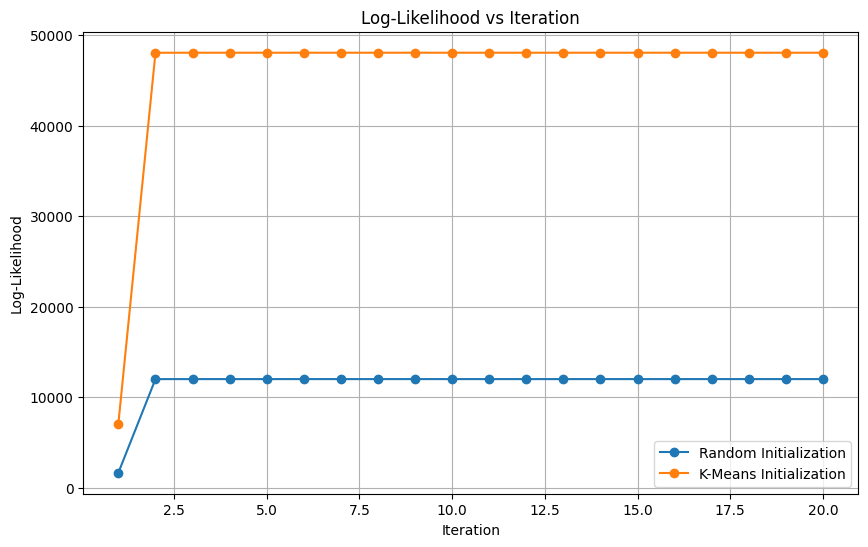

In [ ]:
plotLiklihoods(log_likelihoods_0, log_likelihoods_1)